<div style="text-align: center;">
  <h1 style="color: #347AB7;">Fine-Tuning <code style="background-color: #f5f5f5; color: #EB5424;">Meta Llama2 13B model</code> with Amazon <code style="background-color: #f5f5f5; color: #EB5424;">Bedrock</code></h1>
</div>


## Prerequisites

<p style="font-size: 18px; text-align: left;">Make sure you have executed this <a href="03.1_Initial_Setup.ipynb" style="color: #347AB7; text-decoration: none; font-weight: bold;"><code style="background-color: #f5f5f5; color: #EB5424;">Initial setup</code> Notebook 📓.</a></p>

In this notebook we demonstrate using Boto3 sdk for the fine-tuning and provisioning of [Llama2 13B](#https://ai.meta.com/llama/get-started/) model in Bedrock. You can also do this through the Bedrock Console.

<div style="text-align: left;">

  <h3 style="color: #347AB7;">1. Initial <code style="background-color: #f5f5f5; color: #EB5424;">setup</code> ✅</h3>

  <h4 style="color: #347AB7; margin-left: 20px;"> a) Prepare the dataset for fine-tuning ✅</h4>

  <h4 style="color: #347AB7; margin-left: 20px;"> b) Upload the dataset to S3 ✅</h4>

  <h3 style="color: #347AB7;">2. Customize the <code style="background-color: #f5f5f5; color: #EB5424;">model</code> with fine-tuning 🎨</h3>

  <h3 style="color: #347AB7;">3. Provision the custom <code style="background-color: #f5f5f5; color: #EB5424;">model</code> for inference 🚀</h3>

  <h3 style="color: #347AB7;">4. Test the custom <code style="background-color: #f5f5f5; color: #EB5424;">model</code>🔬</h3>

  <h3 style="color: #347AB7;">5. Evaluate the Provisioned Custom <code style="background-color: #f5f5f5; color: #EB5424;">model</code> 🔎</h3>

  <h3 style="color: #347AB7;">6. Delete the provisioned model to <code style="background-color: #f5f5f5; color: #EB5424;">save cost</code> 💸</h3>

</div>


<h2 style="color: #347AB7;">1. Initial <code style="background-color: #f5f5f5; color: #EB5424;">setup</code> 🛠️ </h2>

In [1]:
## Fetching varialbes from `03.1_Initial_Setup.ipynb` notebook. 

%store -r role_arn
%store -r s3_train_uri
%store -r s3_validation_uri
%store -r s3_test_uri
%store -r bucket_name

In [2]:
import pprint
pprint.pp(role_arn)
pprint.pp(s3_train_uri)
pprint.pp(s3_validation_uri)
pprint.pp(s3_test_uri)
pprint.pp(bucket_name)

'arn:aws:iam::507922848584:role/AmazonBedrockCustomizationRole1'
's3://bedrock-customization-us-east-1-507922848584/fine-tuning-datasets/train/train-cnn-5K.jsonl'
's3://bedrock-customization-us-east-1-507922848584/fine-tuning-datasets/validation/validation-cnn-1K.jsonl'
's3://bedrock-customization-us-east-1-507922848584/fine-tuning-datasets/test/test-cnn-10.jsonl'
'bedrock-customization-us-east-1-507922848584'


In [3]:
import warnings
warnings.filterwarnings('ignore')
import json
import os
import sys
import boto3
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
session = boto3.session.Session()
region = session.region_name
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')
aws_account_id = sts_client.get_caller_identity()["Account"]
bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

In [5]:
test_file_name = "test-cnn-10.jsonl"
data_folder = "fine-tuning-datasets"

<h2 style="color: #347AB7;">2. Customize the <code style="background-color: #f5f5f5; color: #EB5424;">model</code> with fine-tuning 🎨</h2>


<div class="alert alert-block alert-info">
<b>Note:</b> Fine-tuning job will take around 60mins to complete with 5K records.</div>

Meta Llama2 customization hyperparameters: 
- `epochs`: The number of iterations through the entire training dataset and can take up any integer values in the range of 1-10, with a default value of 2.
- `batchSize`: The number of samples processed before updating model parametersand can take up any integer values in the range of 1-64, with a default value of 1.
- `learningRate`:	The rate at which model parameters are updated after each batch	which can take up a float value betweek 0.0-1.0 with a default value set to	1.00E-5.
- `learningRateWarmupSteps`: The number of iterations over which the learning rate is gradually increased to the specified rate and can take any integer value between 0-250 with a default value of 5.

For guidelines on setting hyper-parameters refer to the guidelines provided [here](#https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-guidelines.html)

In [7]:
from datetime import datetime
ts = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Choose the foundation model you want to customize and provide ModelId(find more about model reference at https://docs.aws.amazon.com/bedrock/latest/userguide/bedrock-reference.html)
base_model_id = "meta.llama2-13b-v1:0:4k"

# Select the customization type from "FINE_TUNING" or "CONTINUED_PRE_TRAINING". 
customization_type = "FINE_TUNING"

# Specify the roleArn for your customization job
customization_role = role_arn

# Create a customization job name
customization_job_name = f"llama2-finetune-sm-test-model-{ts}"

# Create a customized model name for your fine-tuned Llama2 model
custom_model_name = f"llama2-finetune-{ts}"

# Define the hyperparameters for fine-tuning Llama2 model
hyper_parameters = {
        "epochCount": "2",
        "batchSize": "1",
        "learningRate": "0.00005",
    }

# Specify your data path for training, validation(optional) and output
training_data_config = {"s3Uri": s3_train_uri}

# # uncomment the below section if you have validation dataset and provide the s3 uri for it. 
validation_data_config = {
        "validators": [{
            "s3Uri": s3_validation_uri
        }]
    }

output_data_config = {"s3Uri": f's3://{bucket_name}/outputs/output-{custom_model_name}'}

# # Create the customization job
bedrock.create_model_customization_job(
                                        customizationType=customization_type,
                                        jobName=customization_job_name,
                                        customModelName=custom_model_name,
                                        roleArn=customization_role,
                                        baseModelIdentifier=base_model_id,
                                        hyperParameters=hyper_parameters,
                                        trainingDataConfig=training_data_config,
                                        validationDataConfig=validation_data_config,
                                        outputDataConfig=output_data_config
                                    )

{'ResponseMetadata': {'RequestId': '4a054273-0e70-4c63-be05-3ee15fc21658',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Tue, 12 Mar 2024 02:50:55 GMT',
   'content-type': 'application/json',
   'content-length': '112',
   'connection': 'keep-alive',
   'x-amzn-requestid': '4a054273-0e70-4c63-be05-3ee15fc21658'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-east-1:507922848584:model-customization-job/meta.llama2-13b-v1:0:4k/qe5a9jvjc2j2'}

### Check Customization Job Status

In [8]:
import time
fine_tune_job = bedrock.get_model_customization_job(jobIdentifier=customization_job_name)["status"]
print(fine_tune_job)

while fine_tune_job == "InProgress":
    time.sleep(60)
    fine_tune_job = bedrock.get_model_customization_job(jobIdentifier=customization_job_name)["status"]
    print (fine_tune_job)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


### Retrieve Custom Model
Once the customization job is finished, you can check your existing custom model(s) and retrieve the modelArn of your fine-tuned Llama2 model.

In [9]:
# You can list your custom models using the command below
bedrock.list_custom_models()

{'ResponseMetadata': {'RequestId': '54bf8be4-efd7-46f6-9593-e25421437af4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 12 Mar 2024 03:52:57 GMT',
   'content-type': 'application/json',
   'content-length': '371',
   'connection': 'keep-alive',
   'x-amzn-requestid': '54bf8be4-efd7-46f6-9593-e25421437af4'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1:507922848584:custom-model/meta.llama2-13b-v1:0:4k/yorojec81ro9',
   'modelName': 'llama2-finetune-2024-03-12-02-50-55',
   'creationTime': datetime.datetime(2024, 3, 12, 2, 50, 55, 973000, tzinfo=tzlocal()),
   'baseModelArn': 'arn:aws:bedrock:us-east-1::foundation-model/meta.llama2-13b-v1:0:4k',
   'baseModelName': '',
   'customizationType': 'FINE_TUNING'}]}

<div class="alert alert-block alert-info">
<b>Note:</b> Please make sure your customization job status is "completed" before proceeding to retrieve the modelArn, otherwise you will run into errors. </div>


In [10]:
# retrieve the modelArn of the fine-tuned model
fine_tune_job = bedrock.get_custom_model(modelIdentifier=custom_model_name)
custom_model_id = fine_tune_job['modelArn']

In [11]:
output_job_name = "model-customization-job-"+fine_tune_job['jobArn'].split('/')[-1]
output_job_name

'model-customization-job-qe5a9jvjc2j2'

### Visualize Training and Validation Loss
Now that we have completed fine-tuning job, lets visualize our results to see if our job is not underfitting or overfitting. 

Download model customization job metrics from S3 and plot the learning curves.

In [12]:
output_metrics_path = f"fine-tuning-datasets/{output_job_name}"

In [13]:
!mkdir $output_metrics_path

In [14]:
train_metrics_s3_prefix=f'outputs/output-{custom_model_name}/{output_job_name}/training_artifacts/step_wise_training_metrics.csv'
validation_metrics_s3_prefix=f'outputs/output-{custom_model_name}/{output_job_name}/validation_artifacts/post_fine_tuning_validation/validation/validation_metrics.csv'

train_metrics_name='train_metrics.csv'
validation_metrics_name='validation_metrics.csv'

train_file_name_local=output_metrics_path+'/'+train_metrics_name
validation_file_name_local=output_metrics_path+'/'+validation_metrics_name

In [16]:
s3_client.download_file(bucket_name, train_metrics_s3_prefix, train_file_name_local)
s3_client.download_file(bucket_name, validation_metrics_s3_prefix, validation_file_name_local)

In [17]:
train_data = pd.read_csv(train_file_name_local)
'''The training loss is at an iteration level. To calculate loss at the epoch level,
    average the iteration-level loss for each epoch'''
train_metrics_epoch=train_data.groupby('epoch_number').mean()
validation_metrics_epoch=pd.read_csv(validation_file_name_local)


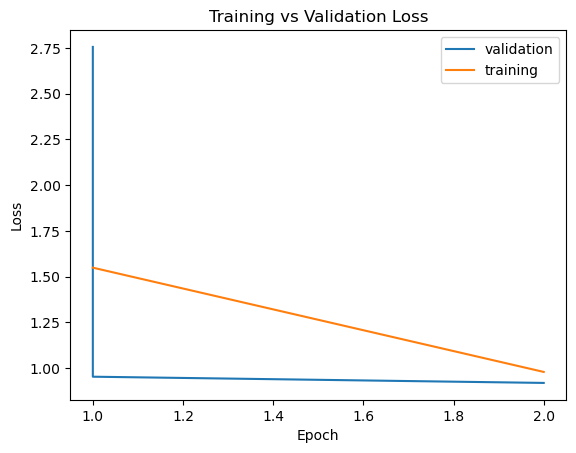

In [18]:
plt.plot(validation_metrics_epoch.epoch_number, validation_metrics_epoch.validation_loss,label='validation')
plt.plot(train_metrics_epoch.index, train_metrics_epoch.training_loss,label='training')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

<h2 style="color: #347AB7;">3. Provision the custom <code style="background-color: #f5f5f5; color: #EB5424;">model</code> for inference 🚀</h2>


<div class="alert alert-block alert-info">
<b>Note:</b> Creating provisioned throughput will take around 20-30mins to complete.</div>

You will need to create provisioned throughput to be able to evaluate the model performance. You can do so through the [console](https://docs.aws.amazon.com/bedrock/latest/userguide/prov-cap-console.html) or use the following api call.

In [19]:
# Create the provision throughput job and retrieve the provisioned model id
provisioned_model_id = bedrock.create_provisioned_model_throughput(
     modelUnits=1,
    # create a name for your provisioned throughput model
     provisionedModelName='test-model-v1-001', 
     modelId=custom_model_id
    )['provisionedModelArn']    

In [20]:
# check provisioned throughput job status
import time
status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId = provisioned_model_id)['status'] 
while status_provisioning == 'Creating':
    time.sleep(60)
    status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId=provisioned_model_id)['status']
    print(status_provisioning)

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


<h2 style="color: #347AB7;">4. Test the custom <code style="background-color: #f5f5f5; color: #EB5424;">model</code>🔬</h2>

Invoke the privisioned custom model.You can replace the follwing prompt_txt with the prompts that are more similar to your fine-tuning dataset, this helps to check whether the fine-tuned model is performing as you expected. 

<div class="alert alert-block alert-info">
<b>Note:</b> Please make sure your provisioned throughput job status becomes InService before proceeding. </div>

In [21]:
# Provide the prompt text 
test_file_path = f'{data_folder}/{test_file_name}'
with open(test_file_path) as f:
    lines = f.read().splitlines()

In [22]:
test_prompt = json.loads(lines[0])['prompt']
reference_summary = json.loads(lines[0])['completion']
print(test_prompt)
print()
print(reference_summary)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

instruction:

Summarize the news article provided below.

input:

The National Trust has replaced antique furniture with beanbags at one of its historic homes in an ‘experiment’ which has enraged heritage experts. Furniture dating back to 1820 was moved from the library at Ickworth House in Suffolk earlier this year and replaced with four brown leatherette bean bags. The move was designed to encourage visitors to ‘dwell and take in the atmosphere’ in the room but it provoked fury from heritage expects who branded the move ‘misguided’. The National Trust has replaced antique furniture with beanbags in the library of Ickworth House, Suffolk . Now it has emerged that similar experiments will take place at nine other of its venues around the country. Art historian Bendor Grosvenor, whose blog post on his Art History News site about I

Construct model input following the format needed by Llama2 model following instructions [here](#https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-meta.html).
Please pay attention to the "Model invocation request body field" section

In [25]:
from pprint import pprint

In [26]:
body = json.dumps({
    "prompt": test_prompt,
    # specify the parameters as needed
    "max_gen_len": 200,
    "temperature": 0.4,
    "top_p": 0.3,
})

# provide the modelId of the provisioned custom model
modelId = provisioned_model_id
accept = 'application/json'
contentType = 'application/json'

# invoke the provisioned custom model
response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)

response_body = json.loads(response.get('body').read())
pprint(response_body)

{'generation': ' response:\n'
               '\n'
               'Beanbags have replaced antique furniture in the library at '
               'Ickworth House .\n'
               'The National Trust said the move was designed to encourage '
               "visitors to 'dwell and take in the atmosphere'\n"
               "But heritage experts have branded the move 'misguided'",
 'generation_token_count': 63,
 'prompt_token_count': 535,
 'stop_reason': 'stop'}


<h2 style="color: #347AB7;">5. Evaluate the Provisioned Custom <code style="background-color: #f5f5f5; color: #EB5424;">Model</code> 🔎</h2>


We will use the [fmeval](https://github.com/aws/fmeval) as the framework to create an evaluation workflow for our fine-tuned model.

FMEval is a library to evaluate Large Language Models (LLMs) and select the best LLM for your use case. The library can help evaluate LLMs for the following tasks:

- Open-ended generation - the production of natural language as a response to general prompts that do not have a pre-defined structure.
- Text summarization - summarizing the most important parts of a text, shortening a text while preserving its meaning.
- Question Answering - the generation of a relevant and accurate response to a question.
- Classification - assigning a category, such as a label or score, to text based on its content.

For our dataset we will leverage the `Text summarization` metrics namely `METEOR`, `ROUGE`, and `BERT` score. 

- `ROUGE`: The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation. ROUGE metrics range between 0 and 1, with higher scores indicating higher similarity between the automatically produced summary and the reference. [Wikipedia link](#https://en.wikipedia.org/wiki/ROUGE_(metric))
- `BERTScore`: calculates the similarity between a summary and reference texts based on the outputs of BERT (Bidirectional Encoder Representations from Transformers), a powerful language model. [Medium article link](#https://haticeozbolat17.medium.com/bertscore-and-rouge-two-metrics-for-evaluating-text-summarization-systems-6337b1d98917)
- `METEOR`: computes a score that represents the semantic alignment and similarity between the so-called reference (original content) and the candidate (summary) sentences. For this, it takes into account both, exact word matches and similar word changes, that preserve the same meaning. [MDPI documentation](#https://www.mdpi.com/2673-2688/4/4/49#:~:text=METEOR)


### Evaluation Dataset

In [27]:
import glob

# Check that the dataset file to be used by the evaluation is present
if not glob.glob("./fine-tuning-datasets/test-cnn-10.jsonl"):
    print("ERROR - please make sure the file, your_evaluation_data_set.jsonl, exists.")

### Model Evaluation Setup

In [29]:
from fmeval.data_loaders.data_config import DataConfig
from fmeval.model_runners.bedrock_model_runner import BedrockModelRunner
from fmeval.constants import MIME_TYPE_JSONLINES
from fmeval.eval_algorithms.summarization_accuracy import SummarizationAccuracy

### Data Config Setup

Below, we create a DataConfig for the local dataset file, xsum_sample.jsonl.
- `dataset_name` is just an identifier for your own reference
- `dataset_uri` is either a local path to a file or an S3 URI
- `dataset_mime_type` is the MIME type of the dataset. Currently, JSON and JSON Lines are supported.
- `model_input_location` and `target_output_location` are JMESPath queries used to find the model inputs and target outputs within the dataset. The values that you specify here depend on the structure of the dataset itself. Take a look at xsum_sample.jsonl to see where "document" and "summary" show up.

In [30]:
path = "fine-tuning-datasets"
config = DataConfig(
                    dataset_name=test_file_name,
                    dataset_uri=test_file_path,
                    dataset_mime_type=MIME_TYPE_JSONLINES,
                    model_input_location="prompt",
                    target_output_location="completion"
                )

### Config Bedrock Model Runner

In [31]:
bedrock_model_runner = BedrockModelRunner(
                                            model_id=provisioned_model_id,
                                            # 'generation' is the field name for response content generated by the fine-tuned and provisioned model (see output formats of Llama2 models follows https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-meta.html - "Model invocation response body field")
                                            output='generation',
                                            # content_template is the input formats of Llama2 model
                                            content_template='{"prompt": $prompt, "max_gen_len": 50, "temperature": 0.1, "top_p": 0.3}',
                                        )

### Create Model Evaluation Job

In this section, we will create an evaluation job using `SummaryAccuracy` class from `fmeval` package with `METEOR, ROUGE, and BERTScores`. 
Please note that this is a sample notebook where we have fine-tuned the model with 5K records and for 2 epochs with learning rate of `0.00005`. For your use case and based on your dataset, when you will fine-tune the model with relevant number of records, and epochs, you might see different results than in this notebook.

In [32]:
# prompt_template is a template for prompt, if you would like to change the prompt to see how it affects the model peformance of your fine-tuned model, you can play around with
# this parameter. E.g. for an Anthropic Claude model, this could be prompt_template_txt="Human: $feature\n\nAssistant:\n"
# the value "$feature" is a placeholder when you have nothing to add to the prompt on top of the "prompt" field in your fine-tuning data.
prompt_template_txt = "$feature"

# call the SummarizationAccuracy class to create the evaluation job with METEOR, ROUGE, and BERT scores
eval_algo = SummarizationAccuracy()
eval_output = eval_algo.evaluate(model=bedrock_model_runner, dataset_config=config, prompt_template=prompt_template_txt, save=True)

[nltk_data] Downloading package wordnet to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2024-03-12 04:07:39,418	WARNING services.py:1889 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 8323915776 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-03-12 04:07:39,465	INFO worker.py:1642 -- Started a local Ray ins

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-12 04:07:56,040	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition]
2024-03-12 04:07:56,041	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:07:56,041	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Repartition 1:   0%|          | 0/75 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/75 [00:00<?, ?it/s]

Running 0:   0%|          | 0/75 [00:00<?, ?it/s]

2024-03-12 04:07:56,207	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(process_batch)]
2024-03-12 04:07:56,208	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:07:56,208	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/75 [00:00<?, ?it/s]

(MapBatches(process_batch) pid=11976) sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
(MapBatches(process_batch) pid=11976) sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


2024-03-12 04:08:03,295	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[Map(ModelRunnerWrapper)]
2024-03-12 04:08:03,296	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:08:03,296	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-03-12 04:08:03,386	INFO actor_pool_map_operator.py:106 -- Map(ModelRunnerWrapper): Waiting for 15 pool actors to start...


(_MapWorker pid=12730) sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml [repeated 15x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_MapWorker pid=12730) sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml [repeated 15x across cluster]


Running 0:   0%|          | 0/75 [00:00<?, ?it/s]

2024-03-12 04:08:30,384	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(_generate_eval_scores)]
2024-03-12 04:08:30,384	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:08:30,385	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/75 [00:00<?, ?it/s]

(Map(_generate_eval_scores) pid=13321) sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml [repeated 15x across cluster]
(Map(_generate_eval_scores) pid=13321) sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml [repeated 15x across cluster]
(Map(_generate_eval_scores) pid=13319) sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml [repeated 6x across cluster]
(Map(_generate_eval_scores) pid=13319) sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml [repeated 6x across cluster]


(BertscoreHelperModel pid=12405) /opt/conda/lib/python3.10/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(BertscoreHelperModel pid=12405)   query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
(BertscoreHelperModel pid=12405) /opt/conda/lib/python3.10/site-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(BertscoreHelperModel pid=12405)   p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))
2024-03-12 04:10:21,027	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to ret

- Aggregate 1:   0%|          | 0/75 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/75 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/75 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-12 04:10:21,227	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-12 04:10:21,228	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:10:21,229	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/75 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/75 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/75 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-12 04:10:21,388	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-12 04:10:21,389	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:10:21,390	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/75 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/75 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/75 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-12 04:10:21,557	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(<lambda>)]
2024-03-12 04:10:21,557	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:10:21,558	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/75 [00:00<?, ?it/s]

2024-03-12 04:10:21,767	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(<lambda>)]
2024-03-12 04:10:21,768	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 04:10:21,768	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/75 [00:00<?, ?it/s]

In [34]:
# Pretty-print the evaluation output (notice the score).
import json
print(json.dumps(eval_output, default=vars, indent=4))

[
    {
        "eval_name": "summarization_accuracy",
        "dataset_name": "test-cnn-10.jsonl",
        "dataset_scores": [
            {
                "name": "meteor",
                "value": 0.39435233359905386
            },
            {
                "name": "rouge",
                "value": 0.2679509674783136
            },
            {
                "name": "bertscore",
                "value": 0.7136923491954803
            }
        ],
        "prompt_template": "$feature",
        "category_scores": null,
        "output_path": "/tmp/eval_results/summarization_accuracy_test-cnn-10.jsonl.jsonl",
        "error": null
    }
]


In [35]:
# Create a Pandas DataFrame to visualize the results
import pandas as pd

data = []

# We obtain the path to the results file from "output_path" in the cell above
with open(f"/tmp/eval_results/summarization_accuracy_test-cnn-10.jsonl.jsonl", "r") as file:
    for line in file:
        data.append(json.loads(line))
df = pd.DataFrame(data)
df['eval_algo'] = df['scores'].apply(lambda x: x[2]['name'])
df['eval_score'] = df['scores'].apply(lambda x: x[2]['value'])
df[0:10]

model_input  \
0  Below is an instruction that describes a task,...   
1  Below is an instruction that describes a task,...   
2  Below is an instruction that describes a task,...   
3  Below is an instruction that describes a task,...   
4  Below is an instruction that describes a task,...   
5  Below is an instruction that describes a task,...   
6  Below is an instruction that describes a task,...   
7  Below is an instruction that describes a task,...   
8  Below is an instruction that describes a task,...   
9  Below is an instruction that describes a task,...   

                                        model_output  \
0   response:\n\nFloyd Mayweather's fight against...   
1   response:\n\nNew York state authorities have ...   
2   response:\n\nBadou Jack outpointed Anthony Di...   
3   response:\n\nChange4Life is promoting dishes ...   
4   response:\n\nBeanbags have replaced antique f...   
5   response:\n\nYahya Rashid, 19, was arrested a...   
6   response:\n\nRoberto Carlos has revealed his ...   
7   response:\n\nBilly Vunipola cited for strikin...   
8   response:\n\nFilipe Luis insists he wants to ...   
9   response:\n\nDale Cregan is on hunger strike ...   

                                       target_output  \
0  response:\n\nUS viewers will have to pay up to...   
1  response:\n\nNew York reports 160 hospitalizat...   
2  response:\n\nBadou Jack beat Anthony Dirrell o...   
3  response:\n\nChange4Life run by Public Health ...   
4  response:\n\nFour brown leatherette bean bags ...   
5  response:\n\nLondon's Metropolitan Police say ...   
6  response:\n\nRoberto Carlos says the pressures...   
7  response:\n\nEngland No 8 cited for incident i...   
8  response:\n\nFilipe Luis signed for Chelsea fr...   
9  response:\n\n31-year-old was transferred to so...   

                                              prompt  \
0  Below is an instruction that describes a task,...   
1  Below is an instruction that describes a task,...   
2  Below is an instruction that describes a task,...   
3  Below is an instruction that describes a task,...   
4  Below is an instruction that describes a task,...   
5  Below is an instruction that describes a task,...   
6  Below is an instruction that describes a task,...   
7  Below is an instruction that describes a task,...   
8  Below is an instruction that describes a task,...   
9  Below is an instruction that describes a task,...   

                                              scores  eval_algo  eval_score  
0  [{'name': 'meteor', 'value': 0.205255050011933...  bertscore    0.664433  
1  [{'name': 'meteor', 'value': 0.460460460460460...  bertscore    0.751766  
2  [{'name': 'meteor', 'value': 0.362090848960474...  bertscore    0.652971  
3  [{'name': 'meteor', 'value': 0.550965403997508...  bertscore    0.769306  
4  [{'name': 'meteor', 'value': 0.459532332295104...  bertscore    0.744286  
5  [{'name': 'meteor', 'value': 0.451971746403957...  bertscore    0.802406  
6  [{'name': 'meteor', 'value': 0.298463356973995...  bertscore    0.677269  
7  [{'name': 'meteor', 'value': 0.290874932903918...  bertscore    0.696025  
8  [{'name': 'meteor', 'value': 0.576884294332211...  bertscore    0.748076  
9  [{'name': 'meteor', 'value': 0.287024909650973...  bertscore    0.630384

<h2 style="color: #347AB7;">6. Delete the provisioned model to <code style="background-color: #f5f5f5; color: #EB5424;">save cost</code> 💸</h2>


<div class="alert alert-block alert-warning">
<b>Warning:</b> Please make sure to delete providsioned throughput with the following code as there will be cost incurred if its left in running state, even if you are not using it. 
</div>

In [ ]:
# delete the provisioned throughput
bedrock.delete_provisioned_model_throughput(provisionedModelId=provisioned_model_id)

<div class="alert alert-block alert-info">
<b>Note:</b> Please finish up the cleaning process by running 03_cleanup.ipynb to clean up the other resources. </div>